## Amazon Fine Food Review - Ensemble Algorithm

In [1]:
# Getting all the imports done

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import seaborn as sns

C:\Users\NamrataT\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect(r'C:\Users\NamrataT\Desktop\EXAM\PYTHON\Amazon Fine Food Reviews\database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
filtered_data['Score'].value_counts()

1    83876
0    16124
Name: Score, dtype: int64

In [4]:
#Sorting data according to Time in ascending order
sorted_data=filtered_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
sorted_data.reset_index(drop=True, inplace=True)

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

In [7]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [8]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

In [9]:
final_score = final['Score']
final_score.shape

(87773,)

In [10]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [11]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below','not','no', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [12]:
# Combining all the above stundents 
from tqdm import tqdm
from bs4 import BeautifulSoup

preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:56<00:00, 1549.29it/s]


## 1) Applying Random Forest

## 1.1) Applying Random Forest on BOW, SET 1

In [13]:
# Getting all the imports done

from sklearn.metrics import accuracy_score
#from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
#from sklearn import cross_validation
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc,roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from scipy.sparse import hstack

In [14]:
from sklearn.model_selection import GridSearchCV

In [15]:
final['Cleaned_Text']=preprocessed_reviews
final['Word Count'] = final['Cleaned_Text'].apply(lambda x:len(x.split()))
#final['Summary Word Count'] = final['Cleaned_Summary'].apply(lambda x:len(x.split()))
final_review = final[['Cleaned_Text','Word Count','Score']]
X = final_review.drop(['Score'],axis=1)
Y = final_review['Score']

In [16]:
# Time Series Split

X_1, X_test, Y_1, Y_test = train_test_split(X,Y,test_size=0.2,shuffle = False)

In [17]:
# Creating Tfidf Vectorizer

bow_vect = CountVectorizer(ngram_range=(1,2) , min_df = 10)
D1_Train = bow_vect.fit_transform(X_1['Cleaned_Text'])
D1_Test = bow_vect.transform(X_test['Cleaned_Text'])
print("Some feature names : ", bow_vect.get_feature_names()[0:10])
print(D1_Train.shape,D1_Test.shape)

Some feature names :  ['aa', 'aback', 'abandon', 'abandoned', 'abdominal', 'ability', 'able', 'able add', 'able buy', 'able chew']
(70218, 40504) (17555, 40504)


In [22]:
'''X_Train_count  =  X_1['Word Count']
X_Test_count =    X_test['Word Count']
print(X_Train_count.shape,X_Test_count.shape)'''

(70218,) (17555,)


In [23]:
'''X_Train_count  =  X_1['Word Count'].values.reshape(-1,1)
X_Test_count = X_test['Word Count'].values.reshape(-1,1)'''

In [24]:
'''import warnings
warnings.filterwarnings('ignore')
word_scalar = StandardScaler()
word_scalar.fit(X_Train_count) 
X_Train_count = word_scalar.transform(X_Train_count)
X_Test_count = word_scalar.transform(X_Test_count)'''

In [25]:
'''from scipy.sparse import hstack
D1_Train = hstack((D1_Train,X_Train_count))
D1_Test = hstack((D1_Test,X_Test_count))'''

In [26]:
'''from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()
scaler.fit(D1_Train)
D1_Train = scaler.transform(D1_Train)
D1_Test = scaler.transform(D1_Test)

print(D1_Train.shape)
print(D1_Test.shape)'''

(70218, 40505)
(17555, 40505)


In [27]:
'''D1_Train=D1_Train.astype('int')
D1_Test=D1_Test.astype('int')
Y_1=Y_1.astype('int')
Y_test=Y_test.astype('int')'''

In [18]:
n_train = D1_Train.get_shape()[0]
n_test = D1_Test.get_shape()[0]
print(n_train)
print(n_test)

70218
17555


In [19]:
tuned_param = [{'max_depth':[2, 3, 4, 5, 6, 7, 8, 9, 10],
               'n_estimators':[5, 10, 50, 100, 200, 500, 1000]
               }]

In [20]:
# Using GridSearchCV
bow_model = GridSearchCV(RandomForestClassifier(class_weight = 'balanced',max_features = 'auto', random_state = 0, n_jobs = -1),tuned_param,cv = 5, scoring = 'roc_auc')
bow_model.fit(D1_Train,Y_1)

print(bow_model.best_estimator_)
print("AUC SCORE : ",bow_model.score(D1_Test,Y_test))

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)
AUC SCORE :  0.9202982832735723


In [21]:
results = bow_model.cv_results_
print(results)

{'mean_fit_time': array([ 7.23896866,  0.6888042 ,  1.33380327,  2.23077312,  3.5543088 ,
        6.76253886, 13.58785362,  0.6502274 ,  0.69806013,  1.16010928,
        1.95214996,  3.99909568,  8.90269451, 17.2964674 ,  0.60462813,
        0.79271574,  1.81218681,  2.67083569,  5.01975846, 11.22402735,
       22.70078363,  0.77933311,  0.70651579,  1.79401636,  3.60838923,
        6.54620643, 13.77088685, 24.15517316,  0.83693161,  0.73412161,
        1.78819876,  3.95285535,  6.97527628, 15.10862417, 27.74649119,
        0.61659584,  0.8010715 ,  1.88474178,  4.02762918,  6.90462141,
       15.11711397, 34.35511799,  0.84045863,  0.77348418,  2.36342683,
        4.12654757,  7.50071263, 19.19451222, 39.55239668,  0.81452708,
        1.08862929,  2.30913324,  5.32828751,  9.26339707, 21.15454893,
       41.34114618,  0.8377214 ,  0.85125127,  2.89685478,  4.19398031,
        9.06627998, 21.70471668, 45.24197083]), 'std_fit_time': array([13.04984914,  0.03749817,  0.12238605,  0.27916

       0.00210889, 0.00103527, 0.00095655])}


In [22]:
X_axis = np.array(results['param_n_estimators'].data, dtype=float)
Y_axis = np.array(results['param_max_depth'].data, dtype=float)

Text(0.5,1,'Train AUC HeatMap')

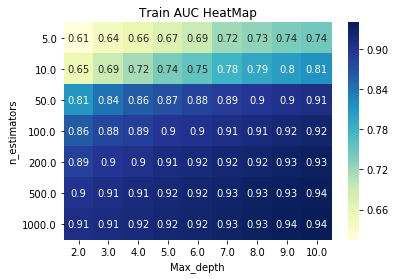

In [23]:
import seaborn as sns
pvt_test = pd.pivot_table(pd.DataFrame(results),values='mean_train_score', index=X_axis, columns=Y_axis)
#pvt_train = pd.pivot_table(pd.DataFrame(results),values='mean_train_score', index=X_axis, columns=Y_axis)
#fig,ax = plt.subplots(1,2)
sns.heatmap(pvt_test,annot = True,cmap="YlGnBu")
#sns.heatmap(pvt_train,annot = True, ax = ax[1],cmap="YlGnBu")
plt.xlabel('Max_depth')
plt.ylabel('n_estimators')
plt.title('Train AUC HeatMap')

Text(0.5,1,'CV AUC HeatMap')

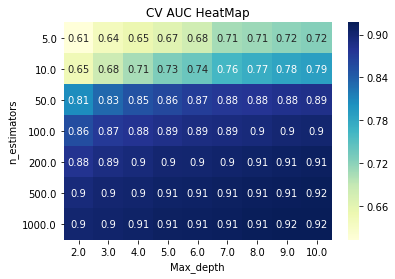

In [24]:
pvt_test = pd.pivot_table(pd.DataFrame(results),values='mean_test_score', index=X_axis, columns=Y_axis)
#pvt_train = pd.pivot_table(pd.DataFrame(results),values='mean_train_score', index=X_axis, columns=Y_axis)
#fig,ax = plt.subplots(1,2)
sns.heatmap(pvt_test,annot = True,cmap="YlGnBu")
#sns.heatmap(pvt_train,annot = True, ax = ax[1],cmap="YlGnBu")
plt.xlabel('Max_depth')
plt.ylabel('n_estimators')
plt.title('CV AUC HeatMap')

In [25]:
# Fitting the model on test data

test_neigh = RandomForestClassifier(class_weight = 'balanced',max_depth = 4,n_estimators=1000)
#test_neigh.set_params(**best_paramList)
test_neigh.fit(D1_Train,Y_1)

predict_test_prob = []
predict_train_prob = []
predicted_labels_test = []
predicted_labels_train = []

# Predicting the model with Train Data
for j in range(0,n_test,1000):
    predicted_labels_test.extend(test_neigh.predict(D1_Test[j:j+1000]))
    predict_test_prob.extend(test_neigh.predict_proba(D1_Test[j:j+1000])[:,1])
    
for k in range(0,n_train,1000):
    predicted_labels_train.extend(test_neigh.predict(D1_Train[k:k+1000]))
    predict_train_prob.extend(test_neigh.predict_proba(D1_Train[k:k+1000])[:,1])
    
print(len(predict_test_prob))
print(len(Y_test))
    
train_fpr, train_tpr, thresholds = roc_curve(Y_1, predict_train_prob)
test_fpr, test_tpr, thresholds = roc_curve(Y_test, predict_test_prob)

print('Algo Run Successfully on D_Test')
print("="*100)

17555
17555
Algo Run Successfully on D_Test


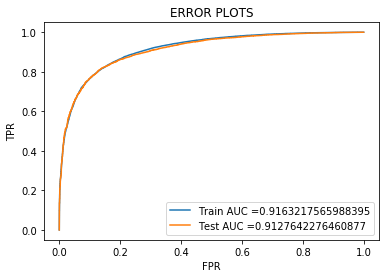

In [26]:
# Plotting the AUC curve on Test and Train Data

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

In [27]:
# Getting the confusion metrics

print('Train Confusion Matrix')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(Y_1,predicted_labels_train).ravel()
print(tr_true_negetive, tr_false_positive, tr_false_negetive, tr_true_positive)
print(confusion_matrix(Y_1,predicted_labels_train))
print("="*120)

print('Test Confusion Matrix')
true_negetive,false_positive, false_negetive, true_positive = confusion_matrix(Y_test,predicted_labels_test).ravel()
print(true_negetive, false_positive, false_negetive, true_positive)
print(confusion_matrix(Y_test,predicted_labels_test))
print("="*120)

Train Confusion Matrix
8771 2496 7082 51869
[[ 8771  2496]
 [ 7082 51869]]
Test Confusion Matrix
2272 642 1876 12765
[[ 2272   642]
 [ 1876 12765]]


Text(0.5,1,'Confusion Matrix of Train Data')

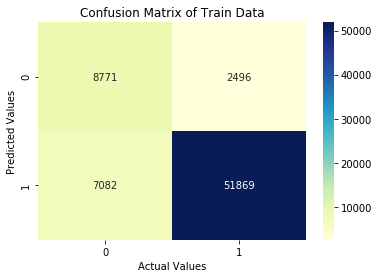

In [28]:
conMatrix= [[tr_true_negetive,tr_false_positive],[tr_false_negetive,tr_true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Train Data')

Text(0.5,1,'Confusion Matrix of Test Data')

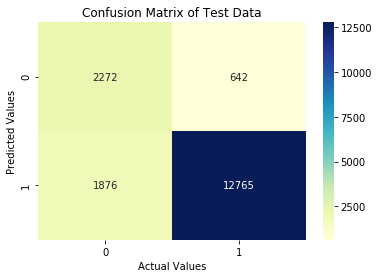

In [29]:
conMatrix= [[true_negetive,false_positive],[false_negetive,true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Test Data')

In [30]:
importances = test_neigh.feature_importances_
indices = np.argsort(importances)[::-1][0:20]
print(indices)
features = bow_vect.get_feature_names()
top20_features = []
feature_importance_top20 = []
for i in indices:
    top20_features.append(features[i])
    feature_importance_top20.append(importances[i])
feature_df = pd.DataFrame(data = top20_features, columns = ['Feature Name'])
feat_imp_df = pd.DataFrame( data = feature_importance_top20 , columns = ['Feature Importance'])
dt_feature_df = pd.concat([feature_df,feat_imp_df],axis = 1)
print(dt_feature_df)

[16121 20937  9394 26236  8848 39965 36106 39930 21247 29039  2893  2049
  2161 38793 39755 29647 27577 22986 36196 10300]
    Feature Name  Feature Importance
0          great            0.019031
1           love            0.017751
2   disappointed            0.014453
3        perfect            0.014263
4      delicious            0.013453
5          would            0.011273
6        thought            0.011034
7          worst            0.010854
8          loves            0.010161
9       received            0.010066
10          best            0.009840
11         awful            0.009652
12           bad            0.009536
13         waste            0.009510
14     wonderful            0.009279
15        return            0.009151
16       product            0.009046
17         money            0.008904
18         threw            0.008558
19          easy            0.008469


In [31]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import urllib
import requests
import matplotlib.pyplot as plt

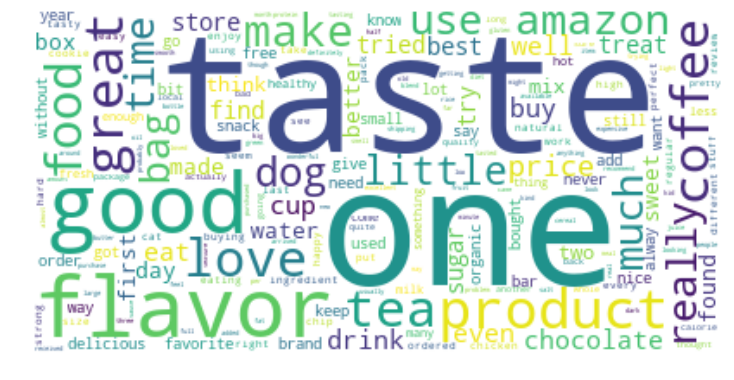

In [32]:
bow_features = " ".join(features)
word_cloud = WordCloud(background_color="white").generate(bow_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## 1.2) Applying Random Forest on TFIDF, SET 2

In [16]:
X_1, X_test, Y_1, Y_test = train_test_split(X,Y,test_size=0.2,shuffle = False)
X_1_train, X_1_cv, Y_1_train, Y_1_cv = train_test_split( X_1, Y_1, test_size=0.2,shuffle = False)
print(X_1_train.shape,Y_1_train.shape)

(56174, 2) (56174,)


In [17]:
df_post_split = pd.concat([X_1_train,Y_1_train],axis=1)
x_positive = df_post_split[df_post_split['Score']==1]
x_negetive = df_post_split[df_post_split['Score']==0]

In [18]:
df_post_split['Score'].value_counts()

1    47504
0     8670
Name: Score, dtype: int64

In [19]:
x_negative_downsample = resample(x_negetive,replace=True,n_samples=37000,random_state=123) 

In [20]:
print(x_negative_downsample.shape, type(x_positive))

(37000, 3) <class 'pandas.core.frame.DataFrame'>


In [21]:
df_upsample = pd.concat([x_positive,x_negative_downsample])
type(df_upsample)
df_upsample.head()

,Cleaned_Text,Word Count,Score
0,bought apartment infested fruit flies hours tr...,30,1
1,really good idea final product outstanding use...,17,1
2,received shipment could hardly wait try produc...,39,1
3,nothing product bother link top page buy used ...,16,1
4,love stuff sugar free rot gums tastes good goi...,12,1


In [22]:
df_upsample['Score'].value_counts()

1    47504
0    37000
Name: Score, dtype: int64

In [23]:
X_Train = df_upsample.drop(['Score'],axis=1)
Y_1_train = df_upsample['Score']
print(X_Train.shape, Y_1_train.shape)

(84504, 2) (84504,)


In [24]:
# Creating Tfidf Vectorizer

tfidf_vect = TfidfVectorizer(ngram_range=(1,2) , min_df = 10)
D2_Train = tfidf_vect.fit_transform(X_Train['Cleaned_Text'])
D2_Cv = tfidf_vect.transform(X_1_cv['Cleaned_Text'])
D2_Test = tfidf_vect.transform(X_test['Cleaned_Text'])
print("Some feature names : ", tfidf_vect.get_feature_names()[0:10])
print(D2_Train.shape,D2_Test.shape)

Some feature names :  ['aa', 'aa dark', 'aafco', 'aback', 'abandon', 'abandoned', 'abc', 'abdomen', 'abdominal', 'ability']
(84504, 60370) (17555, 60370)


In [126]:
'''X_Train_count  =  X_Train['Word Count']
X_Cv_count = X_1_cv['Word Count']
X_Test_count =    X_test['Word Count']
print(X_Train_count.shape,X_Test_count.shape)'''

(84504,) (17555,)


In [127]:
'''X_Train_count  =  X_Train['Word Count'].values.reshape(-1,1)
X_Cv_count = X_1_cv['Word Count'].values.reshape(-1,1)
X_Test_count = X_test['Word Count'].values.reshape(-1,1)'''

In [128]:
'''import warnings
warnings.filterwarnings('ignore')
word_scalar = StandardScaler()
word_scalar.fit(X_Train_count) 
X_Train_count = word_scalar.transform(X_Train_count)
X_Cv_count = word_scalar.transform(X_Cv_count)
X_Test_count = word_scalar.transform(X_Test_count)'''

In [129]:
'''from scipy.sparse import hstack
D2_Train = hstack((D2_Train,X_Train_count))
D2_Cv = hstack((D2_Cv,X_Cv_count))
D2_Test = hstack((D2_Test,X_Test_count))'''

In [130]:
'''from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()
scaler.fit(D2_Train)
D2_Train = scaler.transform(D2_Train)
D2_Cv = scaler.transform(D2_Cv)
D2_Test = scaler.transform(D2_Test)

print(D2_Train.shape)
print(D2_Test.shape)'''

(84504, 60371)
(17555, 60371)


In [131]:
'''D2_Train=D2_Train.astype('int')
D2_Cv = D2_Cv.astype('int')
D2_Test=D2_Test.astype('int')
Y_1_train=Y_1_train.astype('int')
Y_1_cv = Y_1_cv.astype('int')
Y_test=Y_test.astype('int')'''

In [142]:
n_train = D2_Train.get_shape()[0]
n_cv = D2_Cv.get_shape()[0]
n_test = D2_Test.get_shape()[0]
print(n_train)
print(n_test)

84504
17555


In [143]:
# Applying RandomForest

cv_score = []
train_score = []

# creating hyper-parameter list
max_depth = list((2, 3, 4, 5, 6, 7, 8, 9, 10))
n_estimators = list((5, 10, 50, 100, 200, 500,1000))


cv_auc = []
train_auc = []
        
for i in tqdm(max_depth):
    for j in tqdm(n_estimators):
        rf = RandomForestClassifier(random_state = 0,n_jobs = -1, max_depth = i , n_estimators = j,
                                      class_weight='balanced',max_features = 'auto' )
    
        # Fitting the model in Train - CrossValidation
        rf.fit(D2_Train,Y_1_train)
    
        predict_cv_prob = []
        predict_train_prob = []
        
        # Predicting the model with CrossValidation and Train Data
        for j in range(0,n_cv,1000):
            predict_cv_prob.extend(rf.predict_proba(D2_Cv[j:j+1000])[:,1])
    
        for k in range(0,n_train,1000):
            predict_train_prob.extend(rf.predict_proba(D2_Train[k:k+1000])[:,1])
        
        cv_auc.append(roc_auc_score(Y_1_cv,predict_cv_prob))
        train_auc.append(roc_auc_score(Y_1_train,predict_train_prob))

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [33:09<00:00, 243.80s/it]


In [144]:
train_auc = np.round(train_auc,2)
train_auc_rs = np.reshape(train_auc,(9,7))
print(train_auc_rs)

[[0.63 0.68 0.8  0.85 0.87 0.89 0.9 ]
 [0.63 0.73 0.83 0.87 0.88 0.9  0.91]
 [0.66 0.75 0.85 0.88 0.89 0.9  0.91]
 [0.69 0.77 0.87 0.89 0.9  0.91 0.92]
 [0.7  0.79 0.88 0.9  0.91 0.92 0.92]
 [0.72 0.8  0.89 0.91 0.91 0.92 0.93]
 [0.73 0.81 0.9  0.91 0.92 0.93 0.93]
 [0.75 0.82 0.9  0.92 0.93 0.93 0.94]
 [0.78 0.83 0.91 0.92 0.93 0.94 0.94]]


Text(0.5,1,'TFIDF Train AUC HeatMap')

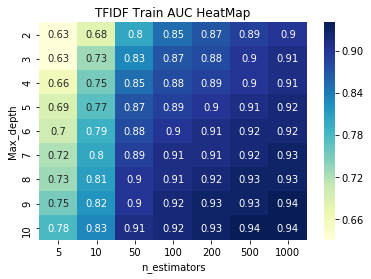

In [145]:
pvt_train = pd.DataFrame(train_auc_rs,index=max_depth, columns=n_estimators)
#pvt_train = pd.pivot_table(pd.DataFrame(results),values='mean_train_score', index=X_axis, columns=Y_axis)
#fig,ax = plt.subplots(1,2)
sns.heatmap(pvt_train,annot = True,cmap="YlGnBu")
#sns.heatmap(pvt_train,annot = True, ax = ax[1],cmap="YlGnBu")
plt.xlabel('n_estimators')
plt.ylabel('Max_depth')
plt.title('TFIDF Train AUC HeatMap')

In [146]:
cv_auc = np.round(cv_auc,2)
cv_auc_rs = np.reshape(cv_auc,(9,7))
print(cv_auc_rs)

[[0.62 0.68 0.79 0.83 0.85 0.87 0.89]
 [0.64 0.71 0.81 0.84 0.86 0.88 0.89]
 [0.66 0.73 0.83 0.86 0.87 0.88 0.89]
 [0.68 0.76 0.84 0.86 0.87 0.89 0.9 ]
 [0.69 0.77 0.85 0.87 0.88 0.89 0.9 ]
 [0.7  0.78 0.86 0.88 0.89 0.89 0.9 ]
 [0.72 0.78 0.86 0.88 0.89 0.9  0.9 ]
 [0.72 0.78 0.87 0.88 0.89 0.9  0.9 ]
 [0.73 0.79 0.87 0.88 0.89 0.9  0.9 ]]


Text(0.5,1,'TFIDF_Word2Vec CV AUC HeatMap')

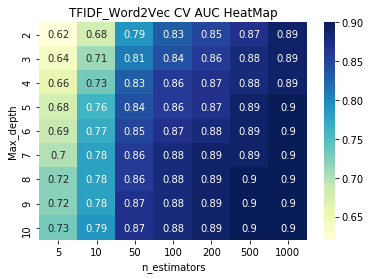

In [147]:
pvt_cv = pd.DataFrame(cv_auc_rs,index=max_depth, columns=n_estimators)
#pvt_train = pd.pivot_table(pd.DataFrame(results),values='mean_train_score', index=X_axis, columns=Y_axis)
#fig,ax = plt.subplots(1,2)
sns.heatmap(pvt_cv,annot = True,cmap="YlGnBu")
#sns.heatmap(pvt_train,annot = True, ax = ax[1],cmap="YlGnBu")
plt.xlabel('n_estimators')
plt.ylabel('Max_depth')
plt.title('TFIDF_Word2Vec CV AUC HeatMap')

In [148]:
# Fitting the model on test data

rf = RandomForestClassifier(random_state = 0,n_jobs = -1, max_depth = 5 , n_estimators = 500,
                            class_weight='balanced',max_features = 'auto' )
    
# Fitting the model in Train - CrossValidation
rf.fit(D2_Train,Y_1_train)
    
predict_test_prob = []
predict_train_prob = []
predicted_labels_test = []
predicted_labels_train = []

# Predicting the model with CrossValidation and Train Data
for j in range(0,n_test,1000):
    predicted_labels_test.extend(rf.predict(D2_Test[j:j+1000]))
    predict_test_prob.extend(rf.predict_proba(D2_Test[j:j+1000])[:,1])
    
for k in range(0,n_train,1000):
    predicted_labels_train.extend(rf.predict(D2_Train[k:k+1000]))
    predict_train_prob.extend(rf.predict_proba(D2_Train[k:k+1000])[:,1])
    
train_fpr, train_tpr, thresholds = roc_curve(Y_1_train, predict_train_prob)
test_fpr, test_tpr, thresholds = roc_curve(Y_test, predict_test_prob)

print('Algo Run Successfully on D_Test')
print("="*100)

Algo Run Successfully on D_Test


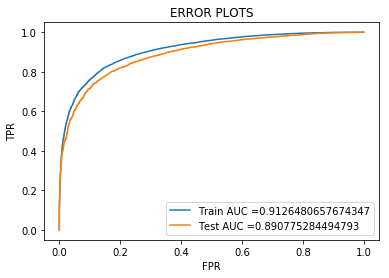

In [149]:
# Plotting the AUC curve on Test and Train Data

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

In [150]:
# Getting the confusion metrics

print('Train Confusion Matrix')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(Y_1_train,predicted_labels_train).ravel()
print(tr_true_negetive, tr_false_positive, tr_false_negetive, tr_true_positive)
print(confusion_matrix(Y_1_train,predicted_labels_train))
print("="*120)

print('Test Confusion Matrix')
true_negetive,false_positive, false_negetive, true_positive = confusion_matrix(Y_test,predicted_labels_test).ravel()
print(true_negetive, false_positive, false_negetive, true_positive)
print(confusion_matrix(Y_test,predicted_labels_test))
print("="*120)

Train Confusion Matrix
29572 7428 6740 40764
[[29572  7428]
 [ 6740 40764]]
Test Confusion Matrix
2202 712 2237 12404
[[ 2202   712]
 [ 2237 12404]]


Text(0.5,1,'Confusion Matrix of Train Data')

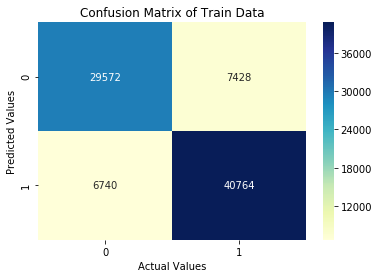

In [151]:
conMatrix= [[tr_true_negetive,tr_false_positive],[tr_false_negetive,tr_true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Train Data')

Text(0.5,1,'Confusion Matrix of Test Data')

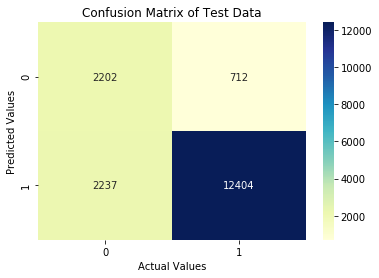

In [152]:
conMatrix= [[true_negetive,false_positive],[false_negetive,true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Test Data')

##### Feature Importance

In [81]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1][0:20]
print(indices)
features_tfidf = tfidf_vect.get_feature_names()
top20_features = []
feature_importance_top20 = []
for i in indices:
    top20_features.append(features_tfidf[i])
    feature_importance_top20.append(importances[i])
feature_df = pd.DataFrame(data = top20_features, columns = ['Feature Name'])
feat_imp_df = pd.DataFrame( data = feature_importance_top20 , columns = ['Feature Importance'])
dt_feature_df = pd.concat([feature_df,feat_imp_df],axis = 1)
print(dt_feature_df)

[23809 59511 13436 53713 59187 14224 12938 18332 30951 38914 35139 57820
 15603 59431 36959 33756 52285 52984 49888 57813]
    Feature Name  Feature Importance
0          great            0.013377
1          would            0.013057
2      delicious            0.013031
3        thought            0.012776
4      wonderful            0.011511
5   disappointed            0.011508
6            day            0.010879
7       favorite            0.010489
8           love            0.010421
9        perfect            0.009980
10          nice            0.009761
11   waste money            0.009583
12          easy            0.009555
13         worst            0.009105
14        opened            0.008737
15         money            0.008432
16         tasty            0.008155
17      terrible            0.008143
18        stores            0.008103
19         waste            0.007652


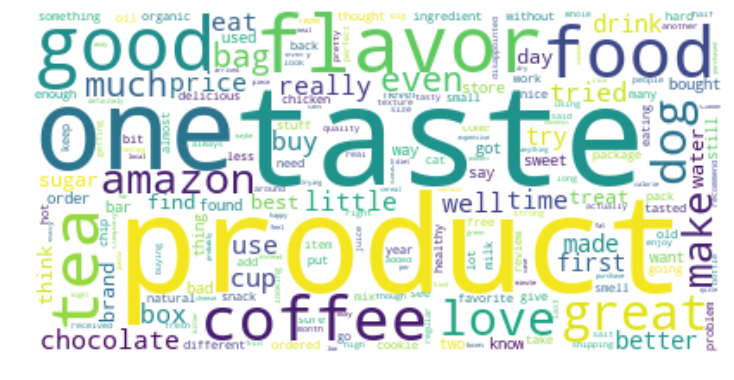

In [82]:
tfidf_features = " ".join(features_tfidf)
word_cloud = WordCloud(background_color="white").generate(tfidf_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## 1.3) Applying Random Forest on Word2Vec, SET 3

In [25]:
# Creating Word2Vec model on Training Data 

list_of_sentence = []
for sentence in X_Train['Cleaned_Text']:
    list_of_sentence.append(sentence.split())
print(len(list_of_sentence))

# Creating Word2Vec model with 50 dimension and min_count=5, it will consider the word only if it appeared more than 5 times

w2v_model = Word2Vec(list_of_sentence, min_count=5, size=50, workers=4)
print(w2v_model.wv.most_similar("good"))
print("="*100)

w2v_words = list(w2v_model.wv.vocab)
print("Total Words Present ", len(w2v_words))
print("Sample Words : ", w2v_words[0:10])
print("="*100)

84504
[('decent', 0.8382846117019653), ('great', 0.8366323709487915), ('fantastic', 0.7722456455230713), ('amazing', 0.7535821199417114), ('terrific', 0.7453205585479736), ('awesome', 0.707108736038208), ('bad', 0.7025691270828247), ('excellent', 0.6623935699462891), ('tasty', 0.6267879605293274), ('nice', 0.6179628372192383)]
Total Words Present  18428
Sample Words :  ['bought', 'apartment', 'infested', 'fruit', 'flies', 'hours', 'trap', 'attracted', 'many', 'within']


In [26]:
# Fitting Average Word2Vec Model on Train Data

sent_vect_train = []
for sent in tqdm(list_of_sentence):
    sentence_vec = np.zeros(50)
    count_words = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            count_words += 1
            sentence_vec += vec
    if count_words != 0:
        sentence_vec /= count_words
    sent_vect_train.append(sentence_vec)
print(len(sent_vect_train))
print(sent_vect_train[0])

100%|███████████████████████████████████████████████████████████████████████████| 84504/84504 [05:59<00:00, 234.85it/s]


84504
[-0.18312854 -0.37347095 -0.16673144  0.31102012 -0.65127945  0.62500264
 -0.11584338  0.03373801 -1.06876091 -0.39683562 -0.59665282 -0.41289741
  0.46522392 -0.16838018  1.09975603 -0.21483721  0.01363872  0.29774549
 -0.44651171  0.10073478  0.28533146 -0.39256653 -0.27958062  0.00799621
  0.43095656  0.04442438 -0.46802171 -0.24956396 -0.11829069  0.50233914
 -0.30790663  0.40414369  0.4163996  -0.36349696  0.04412058 -0.99502827
  0.04008341 -0.46354198  0.40043964 -0.16445846 -0.22339642  0.29604703
 -0.10062206  0.48993858 -0.26005505 -0.31200064 -0.28473243 -0.19862899
  0.02803792  0.20248355]


In [27]:
list_of_sentence = []
for sentence in X_1_cv['Cleaned_Text']:
    list_of_sentence.append(sentence.split())
print(len(list_of_sentence))

14044


In [28]:
sent_vect_cv = []
for sent in tqdm(list_of_sentence):
    sentence_vec = np.zeros(50)
    count_words = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            count_words += 1
            sentence_vec += vec
    if count_words != 0:
        sentence_vec /= count_words
    sent_vect_cv.append(sentence_vec)
print(len(sent_vect_cv))
print(sent_vect_cv[0])

100%|███████████████████████████████████████████████████████████████████████████| 14044/14044 [00:58<00:00, 241.02it/s]


14044
[-0.54852425 -0.07013074  0.22533203  0.07658967  0.36839697 -0.04238525
 -0.5827721  -0.53360025 -0.68088542 -0.38623498 -0.1917444  -0.45870369
  1.44069201  0.68480591  0.3831363   1.01434282  0.91158921  0.1934896
  0.51820495 -0.79795957  0.02368958 -0.40973351 -0.30679268  0.35272674
 -1.16149661 -0.56686832 -0.30206776 -1.36969236 -0.31433611 -0.16962647
 -1.15626627 -0.499872    0.55254179  0.02819174  1.50756059  0.62936188
  1.52057311  0.55887255  0.06372029 -1.10892145 -0.56993029  0.82356559
 -1.59633929 -0.17362526  1.04087284  0.56367651  0.13640614  1.33320883
  0.90022174  0.31979389]


In [29]:
# Applying Word2Vec for Vectorization of X_test

list_of_sentence = []
for sentence in X_test['Cleaned_Text']:
    list_of_sentence.append(sentence.split())
print(len(list_of_sentence))

17555


In [30]:
# Creating Average Word2Vec Vector for Test Data

sent_vect_test = []
for sent in tqdm(list_of_sentence):
    sentence_vec = np.zeros(50)
    count_words = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            count_words += 1
            sentence_vec += vec
    if count_words != 0:
        sentence_vec /= count_words
    sent_vect_test.append(sentence_vec)
print(len(sent_vect_test))
print(sent_vect_test[0])

100%|███████████████████████████████████████████████████████████████████████████| 17555/17555 [01:02<00:00, 279.80it/s]


17555
[-0.30392414  0.15664372  0.19288936  0.48733633  0.17060815 -0.77277685
 -0.13362185 -0.07506363 -0.69622538 -0.31032711  0.20085151 -0.62245138
  0.47637357 -0.76661892  1.04342668  0.34916921 -0.88114528 -0.08938762
 -0.57173998 -0.14140957  0.01157795  0.16203211  0.4305481   0.29242459
 -0.67159176 -0.05748692  0.56274279 -0.06218175  0.60630504 -0.08667508
  0.48829134 -0.4741079   0.27446073  0.29666472  0.05199014 -0.79919765
  0.10483867 -1.62574885  0.40973867  0.65188343 -0.54580909  0.60844949
 -0.84862238  0.39805876 -0.43118262 -0.35837072 -0.26673154  0.54769834
 -0.09802841 -0.51144436]


In [89]:
n_train = len(sent_vect_train)
n_cv = len(sent_vect_cv)
n_test = len(sent_vect_test)
print(n_train)
print(n_test)

84504
17555


In [90]:
D3_Train = np.array(sent_vect_train)
D3_Cv = np.array(sent_vect_cv)
D3_Test = np.array(sent_vect_test)

In [91]:
# Applying XGBoost

cv_score = []
train_score = []

# creating hyper-parameter list
max_depth = list((2, 3, 4, 5, 6, 7, 8, 9, 10))
n_estimators = list((5, 10, 50, 100, 200, 500,1000))


cv_auc = []
train_auc = []
        
for i in tqdm(max_depth):
    for j in tqdm(n_estimators):
        rf = RandomForestClassifier(random_state = 0,n_jobs = -1, max_depth = i , n_estimators = j,
                            class_weight='balanced',max_features = 'auto' )
    
        # Fitting the model in Train - CrossValidation
        rf.fit(D3_Train,Y_1_train)
    
        predict_cv_prob = []
        predict_train_prob = []
        
        # Predicting the model with CrossValidation and Train Data
        for j in range(0,n_cv,1000):
            predict_cv_prob.extend(rf.predict_proba(D3_Cv[j:j+1000])[:,1])
    
        for k in range(0,n_train,1000):
            predict_train_prob.extend(rf.predict_proba(D3_Train[k:k+1000])[:,1])
        
        cv_auc.append(roc_auc_score(Y_1_cv,predict_cv_prob))
        train_auc.append(roc_auc_score(Y_1_train,predict_train_prob))

100%|█████████████████████████████████████████████████████████████████████████████████| 9/9 [1:24:47<00:00, 682.51s/it]


In [92]:
train_auc = np.round(train_auc,2)
train_auc_rs = np.reshape(train_auc,(9,7))
print(train_auc_rs)

[[0.75 0.78 0.8  0.81 0.81 0.81 0.81]
 [0.78 0.8  0.82 0.82 0.82 0.83 0.83]
 [0.8  0.82 0.84 0.84 0.85 0.85 0.85]
 [0.83 0.84 0.86 0.86 0.86 0.86 0.86]
 [0.85 0.86 0.88 0.88 0.88 0.88 0.88]
 [0.87 0.88 0.9  0.9  0.9  0.9  0.9 ]
 [0.9  0.91 0.92 0.92 0.92 0.93 0.93]
 [0.92 0.93 0.95 0.95 0.95 0.95 0.95]
 [0.94 0.96 0.97 0.97 0.97 0.97 0.97]]


Text(0.5,1,'TFIDF Train AUC HeatMap')

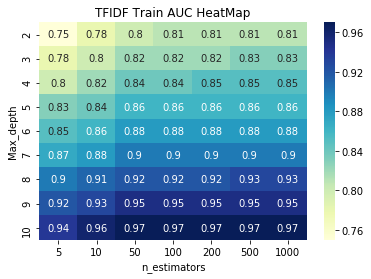

In [93]:
pvt_train = pd.DataFrame(train_auc_rs,index=max_depth, columns=n_estimators)
#pvt_train = pd.pivot_table(pd.DataFrame(results),values='mean_train_score', index=X_axis, columns=Y_axis)
#fig,ax = plt.subplots(1,2)
sns.heatmap(pvt_train,annot = True,cmap="YlGnBu")
#sns.heatmap(pvt_train,annot = True, ax = ax[1],cmap="YlGnBu")
plt.xlabel('n_estimators')
plt.ylabel('Max_depth')
plt.title('TFIDF Train AUC HeatMap')

In [94]:
cv_auc = np.round(cv_auc,2)
cv_auc_rs = np.reshape(cv_auc,(9,7))
print(cv_auc_rs)

[[0.73 0.77 0.78 0.8  0.8  0.8  0.8 ]
 [0.77 0.78 0.8  0.81 0.81 0.81 0.82]
 [0.79 0.8  0.82 0.83 0.83 0.83 0.83]
 [0.81 0.82 0.83 0.84 0.84 0.84 0.84]
 [0.82 0.83 0.85 0.85 0.85 0.85 0.85]
 [0.82 0.84 0.85 0.85 0.85 0.86 0.86]
 [0.83 0.84 0.86 0.86 0.86 0.86 0.86]
 [0.83 0.84 0.86 0.86 0.87 0.87 0.87]
 [0.83 0.84 0.87 0.87 0.87 0.87 0.87]]


Text(0.5,1,'Word2Vec Test AUC HeatMap')

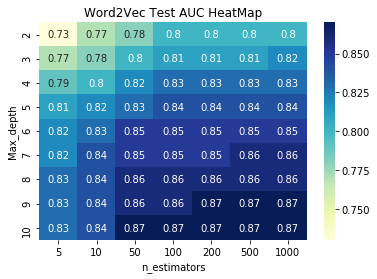

In [95]:
pvt_test = pd.DataFrame(cv_auc_rs,index=max_depth, columns=n_estimators)
sns.heatmap(pvt_test,annot = True,cmap="YlGnBu")
plt.ylabel('Max_depth')
plt.xlabel('n_estimators')
plt.title('Word2Vec Test AUC HeatMap')

In [96]:
# Fitting the model on test data

rf = RandomForestClassifier(random_state = 0,n_jobs = -1, max_depth = 7 , n_estimators = 500 ,
                            class_weight='balanced',max_features = 'auto' )
    
# Fitting the model in Train - CrossValidation
rf.fit(D3_Train,Y_1_train)
    
predict_test_prob = []
predict_train_prob = []
predicted_labels_test = []
predicted_labels_train = []

# Predicting the model with CrossValidation and Train Data
for j in range(0,n_test,1000):
    predicted_labels_test.extend(rf.predict(D3_Test[j:j+1000]))
    predict_test_prob.extend(rf.predict_proba(D3_Test[j:j+1000])[:,1])
    
for k in range(0,n_train,1000):
    predicted_labels_train.extend(rf.predict(D3_Train[k:k+1000]))
    predict_train_prob.extend(rf.predict_proba(D3_Train[k:k+1000])[:,1])
    
train_fpr, train_tpr, thresholds = roc_curve(Y_1_train, predict_train_prob)
test_fpr, test_tpr, thresholds = roc_curve(Y_test, predict_test_prob)

print('Algo Run Successfully on D_Test')
print("="*100)

Algo Run Successfully on D_Test


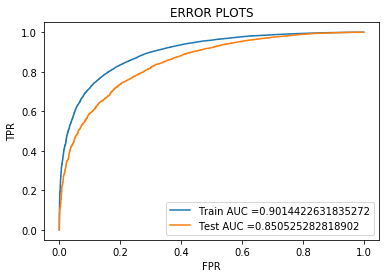

In [97]:
# Plotting the AUC curve on Test and Train Data

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

In [98]:
# Getting the confusion metrics

print('Train Confusion Matrix')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(Y_1_train,predicted_labels_train).ravel()
print(tr_true_negetive, tr_false_positive, tr_false_negetive, tr_true_positive)
print(confusion_matrix(Y_1_train,predicted_labels_train))
print("="*120)

print('Test Confusion Matrix')
true_negetive,false_positive, false_negetive, true_positive = confusion_matrix(Y_test,predicted_labels_test).ravel()
print(true_negetive, false_positive, false_negetive, true_positive)
print(confusion_matrix(Y_test,predicted_labels_test))
print("="*120)

Train Confusion Matrix
30425 6575 8811 38693
[[30425  6575]
 [ 8811 38693]]
Test Confusion Matrix
2167 747 3161 11480
[[ 2167   747]
 [ 3161 11480]]


Text(0.5,1,'Confusion Matrix of Train Data')

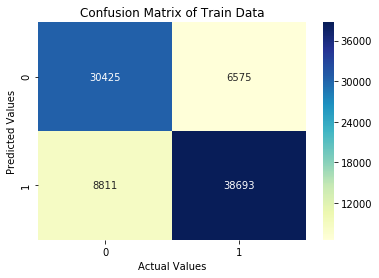

In [99]:
conMatrix= [[tr_true_negetive,tr_false_positive],[tr_false_negetive,tr_true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Train Data')

Text(0.5,1,'Confusion Matrix of Test Data')

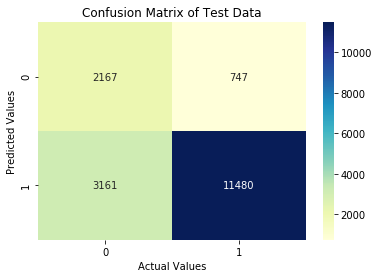

In [100]:
conMatrix= [[true_negetive,false_positive],[false_negetive,true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Test Data')

#### Feature Importance

In [101]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1][0:20]
print(indices)
features_w2v = w2v_words
top20_features = []
feature_importance_top20 = []
for i in indices:
    top20_features.append(features_w2v[i])
    feature_importance_top20.append(importances[i])
feature_df = pd.DataFrame(data = top20_features, columns = ['Feature Name'])
feat_imp_df = pd.DataFrame( data = feature_importance_top20 , columns = ['Feature Importance'])
dt_feature_df = pd.concat([feature_df,feat_imp_df],axis = 1)
print(dt_feature_df)

[18 16 30  3 21  4 22 13 45 23 32  9 24 15 43  1 28 44 41  2]
   Feature Name  Feature Importance
0         crazy            0.128820
1      solution            0.118069
2          idea            0.095362
3         fruit            0.085854
4           one            0.050249
5         flies            0.047981
6       caution            0.038893
7           may            0.037296
8        hardly            0.037192
9       surface            0.035967
10      product            0.033219
11       within            0.031792
12       sticky            0.021721
13         term            0.016631
14     shipment            0.015017
15    apartment            0.014411
16       really            0.014039
17        could            0.013204
18       thumbs            0.012642
19     infested            0.010716


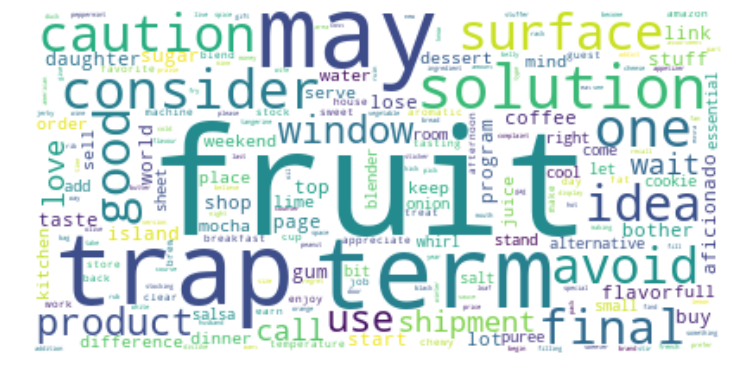

In [102]:
w2v_features = " ".join(features_w2v)
word_cloud = WordCloud(background_color="white").generate(w2v_features)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## 1.4) Applying Random Forest on TFIDF_Word2Vec, SET 4

In [31]:
# Splitting the Training Data into sentences
list_of_sentence = []
for sentence in X_Train['Cleaned_Text']:
    list_of_sentence.append(sentence.split())
print(len(list_of_sentence))

84504


In [32]:
# Tf-Idf Weighted Word2Vec for Training Data

tf_idf_features = tfidf_vect.get_feature_names()
dictionary = dict(zip(tfidf_vect.get_feature_names(), list(tfidf_vect.idf_)))

tfidf_w2v_train = []
for sent in tqdm(list_of_sentence):
    sent_vec = np.zeros(50)
    weighted_sum = 0
    for word in sent:
        if word in w2v_words and word in tf_idf_features:
            vec = w2v_model.wv[word]
            tfidf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += vec * tfidf
            weighted_sum += tfidf
    if weighted_sum != 0:
        sent_vec /= weighted_sum
    tfidf_w2v_train.append(sent_vec)
print(len(tfidf_w2v_train))

100%|██████████████████████████████████████████████████████████████████████████| 84504/84504 [2:05:32<00:00, 12.41it/s]


84504


In [33]:
list_of_sentence_cv = []
for sentence in X_1_cv['Cleaned_Text']:
    list_of_sentence_cv.append(sentence.split())
print(len(list_of_sentence_cv))

14044


In [34]:
tf_idf_features = tfidf_vect.get_feature_names()

tfidf_w2v_cv = []
for sent in tqdm(list_of_sentence_cv):
    sent_vec = np.zeros(50)
    weighted_sum = 0
    for word in sent:
        if word in w2v_words and word in tf_idf_features:
            vec = w2v_model.wv[word]
            tfidf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += vec * tfidf
            weighted_sum += tfidf
    if weighted_sum != 0:
        sent_vec /= weighted_sum
    tfidf_w2v_cv.append(sent_vec)
print(len(tfidf_w2v_cv))

100%|████████████████████████████████████████████████████████████████████████████| 14044/14044 [19:34<00:00, 11.96it/s]


14044


In [35]:
# Splitting the Test Data into sentences

list_of_sentence = []
for sentence in X_test['Cleaned_Text']:
    list_of_sentence.append(sentence.split())
print(len(list_of_sentence))

17555


In [36]:
# Tf-Idf Weighted Word2Vec for Test Data

tf_idf_features = tfidf_vect.get_feature_names()

tfidf_w2v_test = []
for sent in tqdm(list_of_sentence):
    sent_vec = np.zeros(50)
    weighted_sum = 0
    for word in sent:
        if word in w2v_words and word in tf_idf_features:
            vec = w2v_model.wv[word]
            tfidf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += vec * tfidf
            weighted_sum += tfidf
    if weighted_sum != 0:
        sent_vec /= weighted_sum
    tfidf_w2v_test.append(sent_vec)
print(len(tfidf_w2v_test))

100%|████████████████████████████████████████████████████████████████████████████| 17555/17555 [23:39<00:00, 12.37it/s]


17555


In [37]:
n_train = len(tfidf_w2v_train)
n_cv = len(tfidf_w2v_cv)
n_test = len(tfidf_w2v_test)
print(n_train)
print(n_test)

84504
17555


In [38]:
D4_Train = np.array(tfidf_w2v_train)
D4_Cv = np.array(tfidf_w2v_cv)
D4_Test = np.array(tfidf_w2v_test)

In [39]:
# Applying Random Forest

# creating hyper-parameter list
max_depth = list((2, 3, 4, 5, 6, 7, 8, 9, 10))
n_estimators = list((5, 10, 50, 100, 200, 500,1000))


cv_auc = []
train_auc = []
        
for i in tqdm(max_depth):
    for j in tqdm(n_estimators):
        rf = RandomForestClassifier(random_state = 0,n_jobs = -1, max_depth = i , n_estimators = j,
                            class_weight='balanced',max_features = 'auto' )
    
        # Fitting the model in Train - CrossValidation
        rf.fit(D4_Train,Y_1_train)
    
        predict_cv_prob = []
        predict_train_prob = []
        
        # Predicting the model with CrossValidation and Train Data
        for j in range(0,n_cv,1000):
            predict_cv_prob.extend(rf.predict_proba(D4_Cv[j:j+1000])[:,1])
    
        for k in range(0,n_train,1000):
            predict_train_prob.extend(rf.predict_proba(D4_Train[k:k+1000])[:,1])
        
        cv_auc.append(roc_auc_score(Y_1_cv,predict_cv_prob))
        train_auc.append(roc_auc_score(Y_1_train,predict_train_prob))

 43%|████████████████████████████████████                                                | 3/7 [00:49<01:03, 15.92s/it]


100%|█████████████████████████████████████████████████████████████████████████████████| 9/9 [1:09:56<00:00, 556.53s/it]


In [40]:
train_auc = np.round(train_auc,2)
train_auc_rs = np.reshape(train_auc,(9,7))
print(train_auc_rs)

[[0.7  0.72 0.76 0.77 0.77 0.77 0.77]
 [0.73 0.75 0.79 0.79 0.79 0.79 0.8 ]
 [0.76 0.79 0.81 0.81 0.82 0.82 0.82]
 [0.79 0.81 0.83 0.84 0.84 0.84 0.84]
 [0.81 0.83 0.86 0.86 0.86 0.86 0.86]
 [0.84 0.86 0.88 0.89 0.89 0.89 0.89]
 [0.87 0.89 0.91 0.92 0.92 0.92 0.92]
 [0.9  0.92 0.94 0.94 0.94 0.95 0.95]
 [0.93 0.95 0.97 0.97 0.97 0.97 0.97]]


Text(0.5,1,'TFIDF_Word2Vec Train AUC HeatMap')

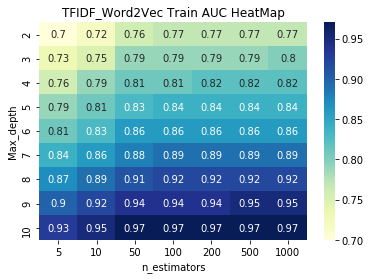

In [41]:
pvt_train = pd.DataFrame(train_auc_rs,index=max_depth, columns=n_estimators)
#pvt_train = pd.pivot_table(pd.DataFrame(results),values='mean_train_score', index=X_axis, columns=Y_axis)
#fig,ax = plt.subplots(1,2)
sns.heatmap(pvt_train,annot = True,cmap="YlGnBu")
#sns.heatmap(pvt_train,annot = True, ax = ax[1],cmap="YlGnBu")
plt.xlabel('n_estimators')
plt.ylabel('Max_depth')
plt.title('TFIDF_Word2Vec Train AUC HeatMap')

In [42]:
cv_auc = np.round(cv_auc,2)
cv_auc_rs = np.reshape(cv_auc,(9,7))
print(cv_auc_rs)

[[0.69 0.72 0.76 0.76 0.76 0.76 0.77]
 [0.73 0.74 0.78 0.79 0.78 0.78 0.79]
 [0.75 0.77 0.79 0.8  0.8  0.8  0.8 ]
 [0.76 0.78 0.81 0.81 0.81 0.81 0.81]
 [0.78 0.8  0.82 0.82 0.82 0.82 0.82]
 [0.79 0.81 0.83 0.83 0.83 0.83 0.83]
 [0.79 0.81 0.83 0.84 0.84 0.84 0.84]
 [0.79 0.81 0.83 0.84 0.84 0.84 0.84]
 [0.79 0.81 0.84 0.84 0.84 0.84 0.84]]


Text(0.5,1,'TFIDF_Word2Vec CV AUC HeatMap')

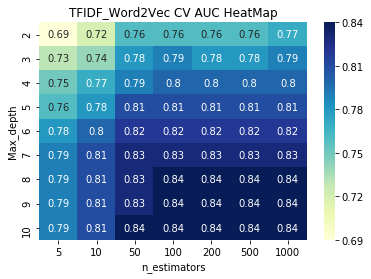

In [43]:
pvt_cv = pd.DataFrame(cv_auc_rs,index=max_depth, columns=n_estimators)
#pvt_train = pd.pivot_table(pd.DataFrame(results),values='mean_train_score', index=X_axis, columns=Y_axis)
#fig,ax = plt.subplots(1,2)
sns.heatmap(pvt_cv,annot = True,cmap="YlGnBu")
#sns.heatmap(pvt_train,annot = True, ax = ax[1],cmap="YlGnBu")
plt.xlabel('n_estimators')
plt.ylabel('Max_depth')
plt.title('TFIDF_Word2Vec CV AUC HeatMap')

In [55]:
# Fitting the model on test data

rf = RandomForestClassifier(random_state = 0,n_jobs = -1, max_depth = 7 , n_estimators = 500,
                            class_weight='balanced',max_features = 'auto' )
    
# Fitting the model in Train - CrossValidation
rf.fit(D4_Train,Y_1_train)
    
predict_test_prob = []
predict_train_prob = []
predicted_labels_test = []
predicted_labels_train = []

# Predicting the model with CrossValidation and Train Data
for j in range(0,n_test,1000):
    predicted_labels_test.extend(rf.predict(D4_Test[j:j+1000]))
    predict_test_prob.extend(rf.predict_proba(D4_Test[j:j+1000])[:,1])
    
for k in range(0,n_train,1000):
    predicted_labels_train.extend(rf.predict(D4_Train[k:k+1000]))
    predict_train_prob.extend(rf.predict_proba(D4_Train[k:k+1000])[:,1])
    
train_fpr, train_tpr, thresholds = roc_curve(Y_1_train, predict_train_prob)
test_fpr, test_tpr, thresholds = roc_curve(Y_test, predict_test_prob)

print('Algo Run Successfully on D_Test')
print("="*100)

Algo Run Successfully on D_Test


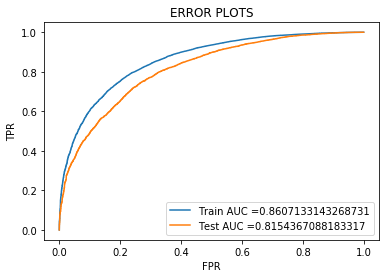

In [53]:
# Plotting the AUC curve on Test and Train Data

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

In [56]:
# Getting the confusion metrics

print('Train Confusion Matrix')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(Y_1_train,predicted_labels_train).ravel()
print(tr_true_negetive, tr_false_positive, tr_false_negetive, tr_true_positive)
print(confusion_matrix(Y_1_train,predicted_labels_train))
print("="*120)

print('Test Confusion Matrix')
true_negetive,false_positive, false_negetive, true_positive = confusion_matrix(Y_test,predicted_labels_test).ravel()
print(true_negetive, false_positive, false_negetive, true_positive)
print(confusion_matrix(Y_test,predicted_labels_test))
print("="*120)

Train Confusion Matrix
29422 7578 8731 38773
[[29422  7578]
 [ 8731 38773]]
Test Confusion Matrix
2051 863 3112 11529
[[ 2051   863]
 [ 3112 11529]]


Text(0.5,1,'Confusion Matrix of Train Data')

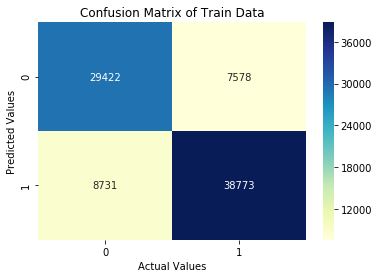

In [47]:
conMatrix= [[tr_true_negetive,tr_false_positive],[tr_false_negetive,tr_true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Train Data')

Text(0.5,1,'Confusion Matrix of Test Data')

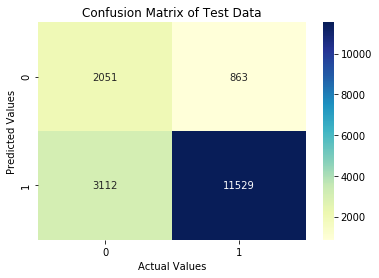

In [48]:
conMatrix= [[true_negetive,false_positive],[false_negetive,true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Test Data')

## Conclusion For Random Forest

In [57]:
# Importing Pretty Table
from prettytable import PrettyTable

In [58]:
x = PrettyTable()
x.field_names = ['Vectorizer', 'Hyper-Parameter 1 Value','Hyper-Parameter 2 Value','AUC']
x.add_row(['BOW','Depth = 4','N_Estimators = 1000','0.91'])
x.add_row(['Tf-Idf','Depth = 5','N_Estimators = 500','0.89'])
x.add_row(['Average Word2Vec','Depth = 7','N_Estimators = 500','0.85'])
x.add_row(['Tf-Idf_Average_Word2Vec','Depth = 7','N_Estimators = 500','0.81'])

print(x)

+-------------------------+-------------------------+-------------------------+------+
|        Vectorizer       | Hyper-Parameter 1 Value | Hyper-Parameter 2 Value | AUC  |
+-------------------------+-------------------------+-------------------------+------+
|           BOW           |        Depth = 4        |   N_Estimators = 1000   | 0.91 |
|          Tf-Idf         |        Depth = 5        |    N_Estimators = 500   | 0.89 |
|     Average Word2Vec    |        Depth = 7        |    N_Estimators = 500   | 0.85 |
| Tf-Idf_Average_Word2Vec |        Depth = 7        |    N_Estimators = 500   | 0.81 |
+-------------------------+-------------------------+-------------------------+------+


## Conclusion

##### We have sampled top 100k datapoints that are highly imbalanced. We have upsampled only the  training data explicilty.
##### We used simple loops to do Cross Validation because Grid Search was taking a lot of time to perform.

##### We have tried to do feature engineering on Tfidf and Bag Of words vectorizer but the performance of the model is decreasing a lot. AUC value decreased rapidly. The confusion matrix became worse with a very less true negative rate and a very high false positive rate. So we didnt go ahead with feature engineering for the final version.
##### Same for Word2Vec and Tfidf_Word2Vec vectorizer. This is the reason we didnt include feature engineering in the final version.
##### We have also performed a feature importance to check if the model is performing good. We have listed the top 20 features along with their weight vector values.
##### We have also visualized the Random Forest for BOW and TFIDF Vectorizer model with Word Cloud. 